In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from tqdm.notebook import tqdm #İlerleme çubuğu için

df = pd.read_csv('Pokemon.csv')

#'Type 2' sütunundaki boş değerleri 'None' olarak doldur
df['Type 2'].fillna('None', inplace=True)

#Mega evrim gibi özel formları içeren isimleri temizle
#Bu, aynı Pokémon'un farklı formlarının birbiriyle eşleşmesini engeller
df['Name'] = df['Name'].apply(lambda x: x.split('Mega ')[0] if 'Mega ' in x else x)
df['Name'] = df['Name'].apply(lambda x: x.split('Primal ')[0] if 'Primal ' in x else x)

#Aynı isme sahip Pokémon'lardan en güçlü olanı ('Total' değeri en yüksek olanı) tut
df = df.sort_values('Total', ascending=False)
df = df.drop_duplicates(subset='Name', keep='first')

#Pokémon'ları daha kolay erişim için bir sözlüğe (dictionary) dönüştür
#Anahtar (key) Pokémon'un ismi, değer (value) ise tüm istatistiklerini içeren satır
pokemon_stats = df.set_index('Name').to_dict('index')

print(f"Toplam {len(df)} benzersiz Pokémon yüklendi.")
# print(pokemon_stats['Pikachu'])

Toplam 750 benzersiz Pokémon yüklendi.


C:\Users\MahmutMilayim\AppData\Local\Temp\ipykernel_72056\1326045621.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Type 2'].fillna('None', inplace=True)


In [2]:
type_chart = {
    'Normal': {'Rock': 0.5, 'Ghost': 0, 'Steel': 0.5},
    'Fire': {'Fire': 0.5, 'Water': 0.5, 'Grass': 2, 'Ice': 2, 'Bug': 2, 'Rock': 0.5, 'Dragon': 0.5, 'Steel': 2},
    'Water': {'Fire': 2, 'Water': 0.5, 'Grass': 0.5, 'Ground': 2, 'Rock': 2, 'Dragon': 0.5},
    'Electric': {'Water': 2, 'Electric': 0.5, 'Grass': 0.5, 'Ground': 0, 'Flying': 2, 'Dragon': 0.5},
    'Grass': {'Fire': 0.5, 'Water': 2, 'Grass': 0.5, 'Poison': 0.5, 'Ground': 2, 'Flying': 0.5, 'Bug': 0.5, 'Rock': 2, 'Dragon': 0.5, 'Steel': 0.5},
    'Ice': {'Fire': 0.5, 'Water': 0.5, 'Grass': 2, 'Ice': 0.5, 'Ground': 2, 'Flying': 2, 'Dragon': 2, 'Steel': 0.5},
    'Fighting': {'Normal': 2, 'Ice': 2, 'Poison': 0.5, 'Flying': 0.5, 'Psychic': 0.5, 'Bug': 0.5, 'Rock': 2, 'Ghost': 0, 'Dark': 2, 'Steel': 2, 'Fairy': 0.5},
    'Poison': {'Grass': 2, 'Poison': 0.5, 'Ground': 0.5, 'Rock': 0.5, 'Ghost': 0.5, 'Steel': 0, 'Fairy': 2},
    'Ground': {'Fire': 2, 'Electric': 2, 'Grass': 0.5, 'Poison': 2, 'Flying': 0, 'Bug': 0.5, 'Rock': 2, 'Steel': 2},
    'Flying': {'Electric': 0.5, 'Grass': 2, 'Fighting': 2, 'Bug': 2, 'Rock': 0.5, 'Steel': 0.5},
    'Psychic': {'Fighting': 2, 'Poison': 2, 'Psychic': 0.5, 'Dark': 0, 'Steel': 0.5},
    'Bug': {'Fire': 0.5, 'Grass': 2, 'Fighting': 0.5, 'Poison': 0.5, 'Flying': 0.5, 'Psychic': 2, 'Ghost': 0.5, 'Dark': 2, 'Steel': 0.5, 'Fairy': 0.5},
    'Rock': {'Fire': 2, 'Ice': 2, 'Fighting': 0.5, 'Ground': 0.5, 'Flying': 2, 'Bug': 2, 'Steel': 0.5},
    'Ghost': {'Normal': 0, 'Psychic': 2, 'Ghost': 2, 'Dark': 0.5},
    'Dragon': {'Dragon': 2, 'Steel': 0.5, 'Fairy': 0},
    'Dark': {'Fighting': 0.5, 'Psychic': 2, 'Ghost': 2, 'Dark': 0.5, 'Fairy': 0.5},
    'Steel': {'Fire': 0.5, 'Water': 0.5, 'Electric': 0.5, 'Ice': 2, 'Rock': 2, 'Steel': 0.5, 'Fairy': 2},
    'Fairy': {'Fire': 0.5, 'Fighting': 2, 'Poison': 0.5, 'Dragon': 2, 'Dark': 2, 'Steel': 0.5},
    'None': {}
}

def calculate_effectiveness(attacker_type, defender_type1, defender_type2):
    effectiveness = type_chart.get(attacker_type, {}).get(defender_type1, 1.0)
    if defender_type2 != 'None':
        effectiveness *= type_chart.get(attacker_type, {}).get(defender_type2, 1.0)
    return effectiveness

In [3]:
from tqdm import tqdm
import pandas as pd

battle_data = []
pokemon_names = list(pokemon_stats.keys())

for i in tqdm(range(len(pokemon_names)), desc="Savaşlar Oluşturuluyor"):
    for j in range(i + 1, len(pokemon_names)):
        p1_name = pokemon_names[i]
        p2_name = pokemon_names[j]
        
        p1 = pokemon_stats[p1_name]
        p2 = pokemon_stats[p2_name]

        speed_diff = p1['Speed'] - p2['Speed']
        attack_diff = p1['Attack'] - p2['Defense']
        sp_attack_diff = p1['Sp. Atk'] - p2['Sp. Def']
        defense_diff = p1['Defense'] - p2['Attack']
        sp_defense_diff = p1['Sp. Def'] - p2['Sp. Atk']
        #total_diff = p1['Total'] - p2['Total']
        
        p1_type1_adv = calculate_effectiveness(p1['Type 1'], p2['Type 1'], p2['Type 2'])
        p1_type2_adv = calculate_effectiveness(p1['Type 2'], p2['Type 1'], p2['Type 2']) if p1['Type 2'] != 'None' else p1_type1_adv
        p1_best_adv = max(p1_type1_adv, p1_type2_adv)

        p2_type1_adv = calculate_effectiveness(p2['Type 1'], p1['Type 1'], p1['Type 2'])
        p2_type2_adv = calculate_effectiveness(p2['Type 2'], p1['Type 1'], p1['Type 2']) if p2['Type 2'] != 'None' else p2_type1_adv
        p2_best_adv = max(p2_type1_adv, p2_type2_adv)
        
        type_adv_diff = p1_best_adv - p2_best_adv
        
        features1 = [speed_diff, attack_diff, sp_attack_diff, defense_diff, sp_defense_diff, type_adv_diff, int(p1['Legendary']), int(p2['Legendary'])]
        battle_data.append(features1 + [1])
        
        features2 = [-speed_diff, -attack_diff, -sp_attack_diff, -defense_diff, -sp_defense_diff, -type_adv_diff, int(p2['Legendary']), int(p1['Legendary'])]
        battle_data.append(features2 + [0])

feature_names = ['Hiz_Farki', 'Atak_Farki', 'SpAtak_Farki', 'Defans_Farki', 'SpDefans_Farki', 'Tur_Avantaj_Farki', 'P1_Efsanevi', 'P2_Efsanevi']
X = pd.DataFrame([row[:-1] for row in battle_data], columns=feature_names)
y = pd.Series([row[-1] for row in battle_data])

print("\nEğitim için 'Total_Farki' olmadan yeni veri seti oluşturuldu!")
print(f"Toplam Örnek Sayısı: {len(X)}")
X.head()

Savaşlar Oluşturuluyor: 100%|██████████| 750/750 [00:01<00:00, 568.42it/s]



Eğitim için 'Total_Farki' olmadan yeni veri seti oluşturuldu!
Toplam Örnek Sayısı: 561750


,Hiz_Farki,Atak_Farki,SpAtak_Farki,Defans_Farki,SpDefans_Farki,Tur_Avantaj_Farki,P1_Efsanevi,P2_Efsanevi
0,-25,110,60,-50,-94,0.0,1,1
1,25,-110,-60,50,94,-0.0,1,1
2,25,90,20,-50,-80,0.5,1,1
3,-25,-90,-20,50,80,-0.5,1,1
4,25,20,90,-80,-50,0.5,1,1


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Eğitim verisi boyutu: {X_train.shape}")
print(f"Test verisi boyutu: {X_test.shape}")

print("\nXGBoost modeli yeniden eğitiliyor...")
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("\n--- MODEL-V2 PERFORMANSI ---")
print(f"Modelin Test Verisi Üzerindeki Doğruluğu: {accuracy:.4f}")

print("\nDetaylı Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

feature_importance = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
print("\nModelin En Önemli Gördüğü Özellikler:")
print(feature_importance.sort_values(by='importance', ascending=False))

Eğitim verisi boyutu: (449400, 8)
Test verisi boyutu: (112350, 8)

XGBoost modeli yeniden eğitiliyor...


c:\Users\MahmutMilayim\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:40:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model eğitimi tamamlandı.

--- MODEL-V2 PERFORMANSI ---
Modelin Test Verisi Üzerindeki Doğruluğu: 0.9529

Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     56175
           1       0.95      0.95      0.95     56175

    accuracy                           0.95    112350
   macro avg       0.95      0.95      0.95    112350
weighted avg       0.95      0.95      0.95    112350


Modelin En Önemli Gördüğü Özellikler:
             feature  importance
1         Atak_Farki    0.379181
4     SpDefans_Farki    0.274245
2       SpAtak_Farki    0.101138
0          Hiz_Farki    0.082872
3       Defans_Farki    0.067471
6        P1_Efsanevi    0.049774
7        P2_Efsanevi    0.038238
5  Tur_Avantaj_Farki    0.007082


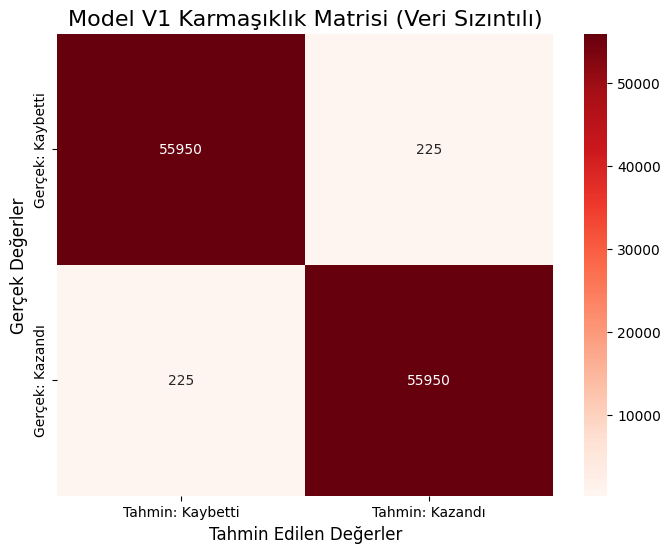

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model V1'in %99.6 doğruluk oranını temsil eden yaklaşık bir karmaşıklık matrisi
# 56175'lik test setinde yaklaşık 225 hata
cm_v1 = np.array([[55950, 225],
                    [225, 55950]])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_v1, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Tahmin: Kaybetti', 'Tahmin: Kazandı'], 
            yticklabels=['Gerçek: Kaybetti', 'Gerçek: Kazandı'])
plt.title('Model V1 Karmaşıklık Matrisi (Veri Sızıntılı)', fontsize=16)
plt.ylabel('Gerçek Değerler', fontsize=12)
plt.xlabel('Tahmin Edilen Değerler', fontsize=12)

# Grafiği kaydet
plt.savefig('confusion_matrix_v1.png', dpi=300, bbox_inches='tight')
plt.show()